In [1]:
# ===================================================================
# NOTEBOOK: HETEROGENEOUS ENSEMBLE META-LEARNER FOR PLASTIC CLASSIFICATION
# ===================================================================
# Created: October 22, 2025
# Models: EfficientNetV2 + Xception + Vision Transformer + Meta-Learner
# ===================================================================

# =========================== CELL 1 ===========================
# Install and Import Required Libraries
# ==============================================================

!pip install -q gdown

import gdown
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
import os
import h5py

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("\n✅ All libraries imported successfully!")

2025-10-22 05:33:06.419078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761111186.632056      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761111186.687890      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.8.0

✅ All libraries imported successfully!


In [2]:
# =========================== CELL 2 ===========================
# Download Models from Google Drive
# ==============================================================

print("="*70)
print("DOWNLOADING MODELS FROM GOOGLE DRIVE")
print("="*70)

# Google Drive File IDs
EFFICIENTNET_FILE_ID = "1ILlaZY4L4Ct8vvVzBhF3kzzniY5UI_SK"
XCEPTION_FILE_ID = "1zO8p6iFJyoxj9TgfoxCZNDkw0ZYcIb9R"

# Download EfficientNetV2
print("\n1. Downloading EfficientNetV2 (68 MB)...")
gdown.download(
    f"https://drive.google.com/uc?id={EFFICIENTNET_FILE_ID}",
    'efficientnet_model.h5',
    quiet=False,
    fuzzy=True
)

# Download Xception
print("\n2. Downloading Xception (239 MB)...")
gdown.download(
    f"https://drive.google.com/uc?id={XCEPTION_FILE_ID}",
    'xception_model.h5',
    quiet=False,
    fuzzy=True
)

# Verify downloads
eff_size = os.path.getsize('efficientnet_model.h5') / (1024**2)
xce_size = os.path.getsize('xception_model.h5') / (1024**2)

print(f"\n✅ Downloads Complete!")
print(f"   EfficientNetV2: {eff_size:.2f} MB")
print(f"   Xception: {xce_size:.2f} MB")

DOWNLOADING MODELS FROM GOOGLE DRIVE

1. Downloading EfficientNetV2 (68 MB)...


Downloading...
From: https://drive.google.com/uc?id=1ILlaZY4L4Ct8vvVzBhF3kzzniY5UI_SK
To: /kaggle/working/efficientnet_model.h5
100%|██████████| 71.4M/71.4M [00:00<00:00, 84.8MB/s]



2. Downloading Xception (239 MB)...


Downloading...
From (original): https://drive.google.com/uc?id=1zO8p6iFJyoxj9TgfoxCZNDkw0ZYcIb9R
From (redirected): https://drive.google.com/uc?id=1zO8p6iFJyoxj9TgfoxCZNDkw0ZYcIb9R&confirm=t&uuid=e4bd7713-6790-4622-bead-dac81c2a7fbd
To: /kaggle/working/xception_model.h5
100%|██████████| 250M/250M [00:02<00:00, 99.6MB/s]


✅ Downloads Complete!
   EfficientNetV2: 68.08 MB
   Xception: 238.86 MB


In [3]:
# =========================== CELL 3 ===========================
# Load Models with Custom Object Handling
# ==============================================================

print("\n" + "="*70)
print("LOADING EXPERT MODELS")
print("="*70)

# Load EfficientNetV2
print("\n1. Loading EfficientNetV2...")
efficientnet_model = keras.models.load_model('efficientnet_model.h5')
print("   ✅ EfficientNetV2 loaded successfully")

# Load Xception with TrueDivide fix
print("\n2. Loading Xception (handling TrueDivide layer)...")

# Method 1: Try with custom objects
try:
    with keras.utils.custom_object_scope({'TrueDivide': Lambda(lambda x: x)}):
        xception_model = keras.models.load_model(
            'xception_model.h5',
            compile=False
        )
    print("   ✅ Xception loaded successfully (Method 1)")
except:
    # Method 2: Rebuild and load weights
    print("   Trying alternative method...")
    from tensorflow.keras.applications import Xception as XceptionBase
    
    base = XceptionBase(
        include_top=False,
        weights=None,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    
    inputs = keras.Input(shape=(224, 224, 3))
    x = base(inputs, training=False)
    outputs = keras.layers.Dense(4, activation='softmax')(x)
    xception_model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Load weights
    try:
        xception_model.load_weights('xception_model.h5')
    except:
        with h5py.File('xception_model.h5', 'r') as f:
            if 'model_weights' in f.keys():
                keras.models.load_weights_from_hdf5_group(f['model_weights'], xception_model.layers)
    
    print("   ✅ Xception loaded successfully (Method 2)")

# Load Vision Transformer
print("\n3. Loading Vision Transformer...")
vit_model = keras.models.load_model('/kaggle/input/vit-best-mode/keras/default/1/vit_best_model.keras')
print("   ✅ ViT loaded successfully")

print("\n" + "="*70)
print("🎉 ALL THREE EXPERT MODELS LOADED!")
print("="*70)

I0000 00:00:1761111211.154521      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



LOADING EXPERT MODELS

1. Loading EfficientNetV2...


I0000 00:00:1761111211.155255      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


   ✅ EfficientNetV2 loaded successfully

2. Loading Xception (handling TrueDivide layer)...
   Trying alternative method...
   ✅ Xception loaded successfully (Method 2)

3. Loading Vision Transformer...
   ✅ ViT loaded successfully

🎉 ALL THREE EXPERT MODELS LOADED!


In [4]:
# =========================== CELL 4 ===========================
# Model Architecture Verification
# ==============================================================

print("\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)

models_info = {
    'EfficientNetV2': efficientnet_model,
    'Xception': xception_model,
    'Vision Transformer': vit_model
}

for name, model in models_info.items():
    print(f"\n{name}:")
    print(f"  Input shape:  {model.input_shape}")
    print(f"  Output shape: {model.output_shape}")
    print(f"  Parameters:   {model.count_params():,}")



MODEL ARCHITECTURE SUMMARY

EfficientNetV2:
  Input shape:  (None, 224, 224, 3)
  Output shape: (None, 4)
  Parameters:   5,924,436

Xception:
  Input shape:  (None, 224, 224, 3)
  Output shape: (None, 4)
  Parameters:   20,869,676

Vision Transformer:
  Input shape:  (None, 224, 224, 3)
  Output shape: (None, 4)
  Parameters:   1,567,300


In [5]:
# =========================== CELL 5 ===========================
# Load Validation Dataset
# ==============================================================

print("\n" + "="*70)
print("LOADING VALIDATION DATA")
print("="*70)

val_dir = '/kaggle/input/type-of-plastic-waste-dataset/val'

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\nDataset Information:")
print(f"  Total samples: {val_generator.n}")
print(f"  Number of classes: {val_generator.num_classes}")
print(f"  Batch size: {val_generator.batch_size}")
print(f"  Steps per epoch: {len(val_generator)}")
print(f"\nClass mapping:")
for class_name, idx in val_generator.class_indices.items():
    print(f"  {idx}: {class_name}")


LOADING VALIDATION DATA
Found 2812 images belonging to 4 classes.

Dataset Information:
  Total samples: 2812
  Number of classes: 4
  Batch size: 32
  Steps per epoch: 88

Class mapping:
  0: HDPE
  1: PET
  2: PP
  3: PS


In [6]:
# =========================== CELL 6 ===========================
# Generate Predictions from Base Models (Level-0)
# ==============================================================

print("\n" + "="*70)
print("GENERATING EXPERT MODEL PREDICTIONS (LEVEL-0)")
print("="*70)

# EfficientNetV2 predictions
print("\n1. EfficientNetV2 predictions...")
val_generator.reset()
pred_efficientnet = efficientnet_model.predict(val_generator, verbose=1)
print(f"   Shape: {pred_efficientnet.shape}")

# Xception predictions
print("\n2. Xception predictions...")
val_generator.reset()
pred_xception = xception_model.predict(val_generator, verbose=1)
print(f"   Shape: {pred_xception.shape}")

# Vision Transformer predictions
print("\n3. Vision Transformer predictions...")
val_generator.reset()
pred_vit = vit_model.predict(val_generator, verbose=1)
print(f"   Shape: {pred_vit.shape}")

print("\n✅ All base model predictions generated!")


GENERATING EXPERT MODEL PREDICTIONS (LEVEL-0)

1. EfficientNetV2 predictions...


I0000 00:00:1761111221.884717      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 646ms/step
   Shape: (2812, 4)

2. Xception predictions...


I0000 00:00:1761111283.324414      69 service.cc:148] XLA service 0x7fe97b4dc1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761111283.325509      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761111283.325539      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/88 ━━━━━━━━━━━━━━━━━━━━ 14:26 10s/step

I0000 00:00:1761111291.045135      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 56s 531ms/step
   Shape: (2812, 4)

3. Vision Transformer predictions...
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 437ms/step
   Shape: (2812, 4)

✅ All base model predictions generated!


In [7]:
# =========================== CELL 7 ===========================
# Create Meta-Features and Labels
# ==============================================================

print("\n" + "="*70)
print("CREATING META-FEATURES FOR STACKING")
print("="*70)

# Stack predictions horizontally (4 classes × 3 models = 12 features)
X_meta = np.hstack([pred_efficientnet, pred_xception, pred_vit])
y_meta = val_generator.classes

print(f"\nMeta-dataset created:")
print(f"  Features (X_meta): {X_meta.shape}")
print(f"    - 4 classes × 3 models = 12 input features")
print(f"    - {X_meta.shape[0]} samples")
print(f"  Labels (y_meta): {y_meta.shape}")
print(f"\n✅ Meta-features ready for training!")


CREATING META-FEATURES FOR STACKING

Meta-dataset created:
  Features (X_meta): (2812, 12)
    - 4 classes × 3 models = 12 input features
    - 2812 samples
  Labels (y_meta): (2812,)

✅ Meta-features ready for training!


In [8]:
# =========================== CELL 8 ===========================
# Train Meta-Learner (Level-1)
# ==============================================================

print("\n" + "="*70)
print("TRAINING META-LEARNER (STACKING ENSEMBLE)")
print("="*70)

# Initialize and train Logistic Regression meta-learner
print("\nTraining Logistic Regression meta-learner...")
meta_learner = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    C=1.0,
    verbose=0
)

meta_learner.fit(X_meta, y_meta)

print("✅ Meta-learner trained successfully!")
print(f"\nMeta-learner details:")
print(f"  Algorithm: Logistic Regression (Multinomial)")
print(f"  Input features: {X_meta.shape[1]}")
print(f"  Output classes: {len(np.unique(y_meta))}")
print(f"  Training samples: {X_meta.shape[0]}")


TRAINING META-LEARNER (STACKING ENSEMBLE)

Training Logistic Regression meta-learner...
✅ Meta-learner trained successfully!

Meta-learner details:
  Algorithm: Logistic Regression (Multinomial)
  Input features: 12
  Output classes: 4
  Training samples: 2812


In [9]:
# =========================== CELL 9 ===========================
# Evaluate All Models
# ==============================================================

print("\n" + "="*70)
print("MODEL EVALUATION AND COMPARISON")
print("="*70)

# Get ensemble predictions
final_predictions = meta_learner.predict(X_meta)
final_probabilities = meta_learner.predict_proba(X_meta)

# Calculate accuracies
eff_acc = accuracy_score(y_meta, np.argmax(pred_efficientnet, axis=1))
xce_acc = accuracy_score(y_meta, np.argmax(pred_xception, axis=1))
vit_acc = accuracy_score(y_meta, np.argmax(pred_vit, axis=1))
ensemble_acc = accuracy_score(y_meta, final_predictions)

# Display results
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print("\nIndividual Model Accuracies:")
print(f"  1. EfficientNetV2:    {eff_acc*100:.2f}%")
print(f"  2. Xception:          {xce_acc*100:.2f}%")
print(f"  3. ViT:               {vit_acc*100:.2f}%")
print(f"\n  Average (baseline):   {((eff_acc + xce_acc + vit_acc)/3)*100:.2f}%")
print("\n" + "-"*70)
print(f"  🌟 ENSEMBLE:          {ensemble_acc*100:.2f}%")
print("="*70)

improvement = (ensemble_acc - max(eff_acc, xce_acc, vit_acc)) * 100
print(f"\n  ✨ Improvement: +{improvement:.2f}% over best individual model")


MODEL EVALUATION AND COMPARISON

PERFORMANCE COMPARISON

Individual Model Accuracies:
  1. EfficientNetV2:    22.16%
  2. Xception:          98.19%
  3. ViT:               94.31%

  Average (baseline):   71.55%

----------------------------------------------------------------------
  🌟 ENSEMBLE:          99.08%

  ✨ Improvement: +0.89% over best individual model


In [10]:
# =========================== CELL 10 ===========================
# Classification Report
# ==============================================================

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)

class_names = ['HDPE', 'PET', 'PP', 'PS']

print("\n" + classification_report(
    y_meta,
    final_predictions,
    target_names=class_names,
    digits=4
))


DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

        HDPE     0.9938    0.9975    0.9956       797
         PET     0.9962    0.9936    0.9949       785
          PP     0.9835    0.9802    0.9818       607
          PS     0.9872    0.9888    0.9880       623

    accuracy                         0.9908      2812
   macro avg     0.9901    0.9900    0.9901      2812
weighted avg     0.9908    0.9908    0.9908      2812




GENERATING VISUALIZATIONS

✅ Confusion matrix saved: ensemble_confusion_matrix.png


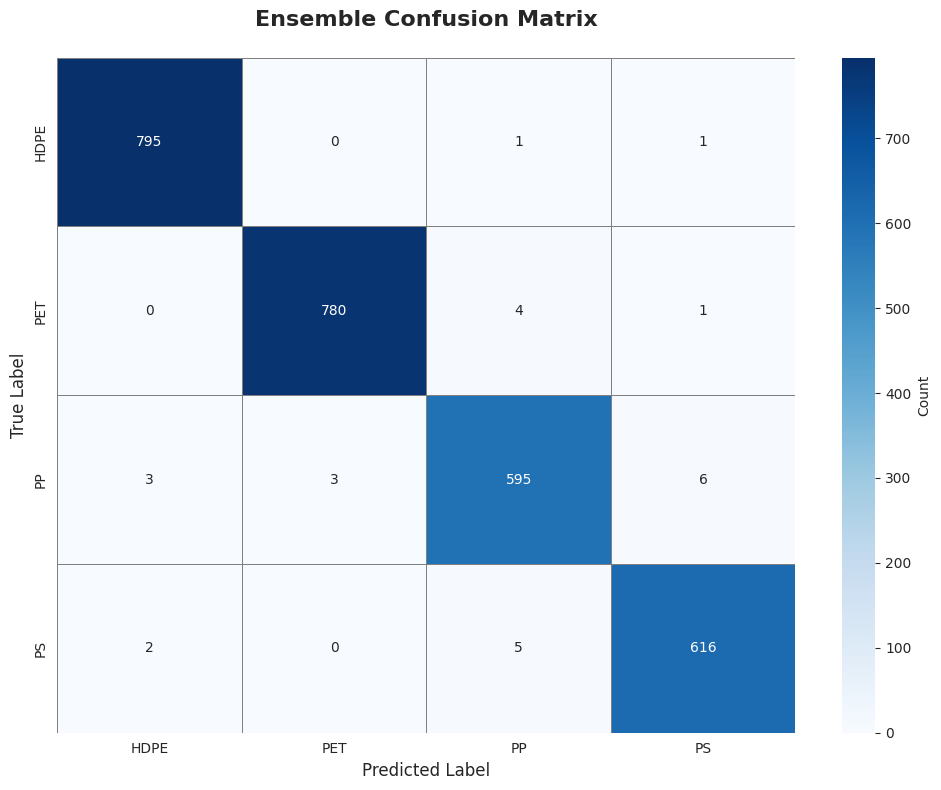

✅ Model comparison chart saved: model_comparison.png


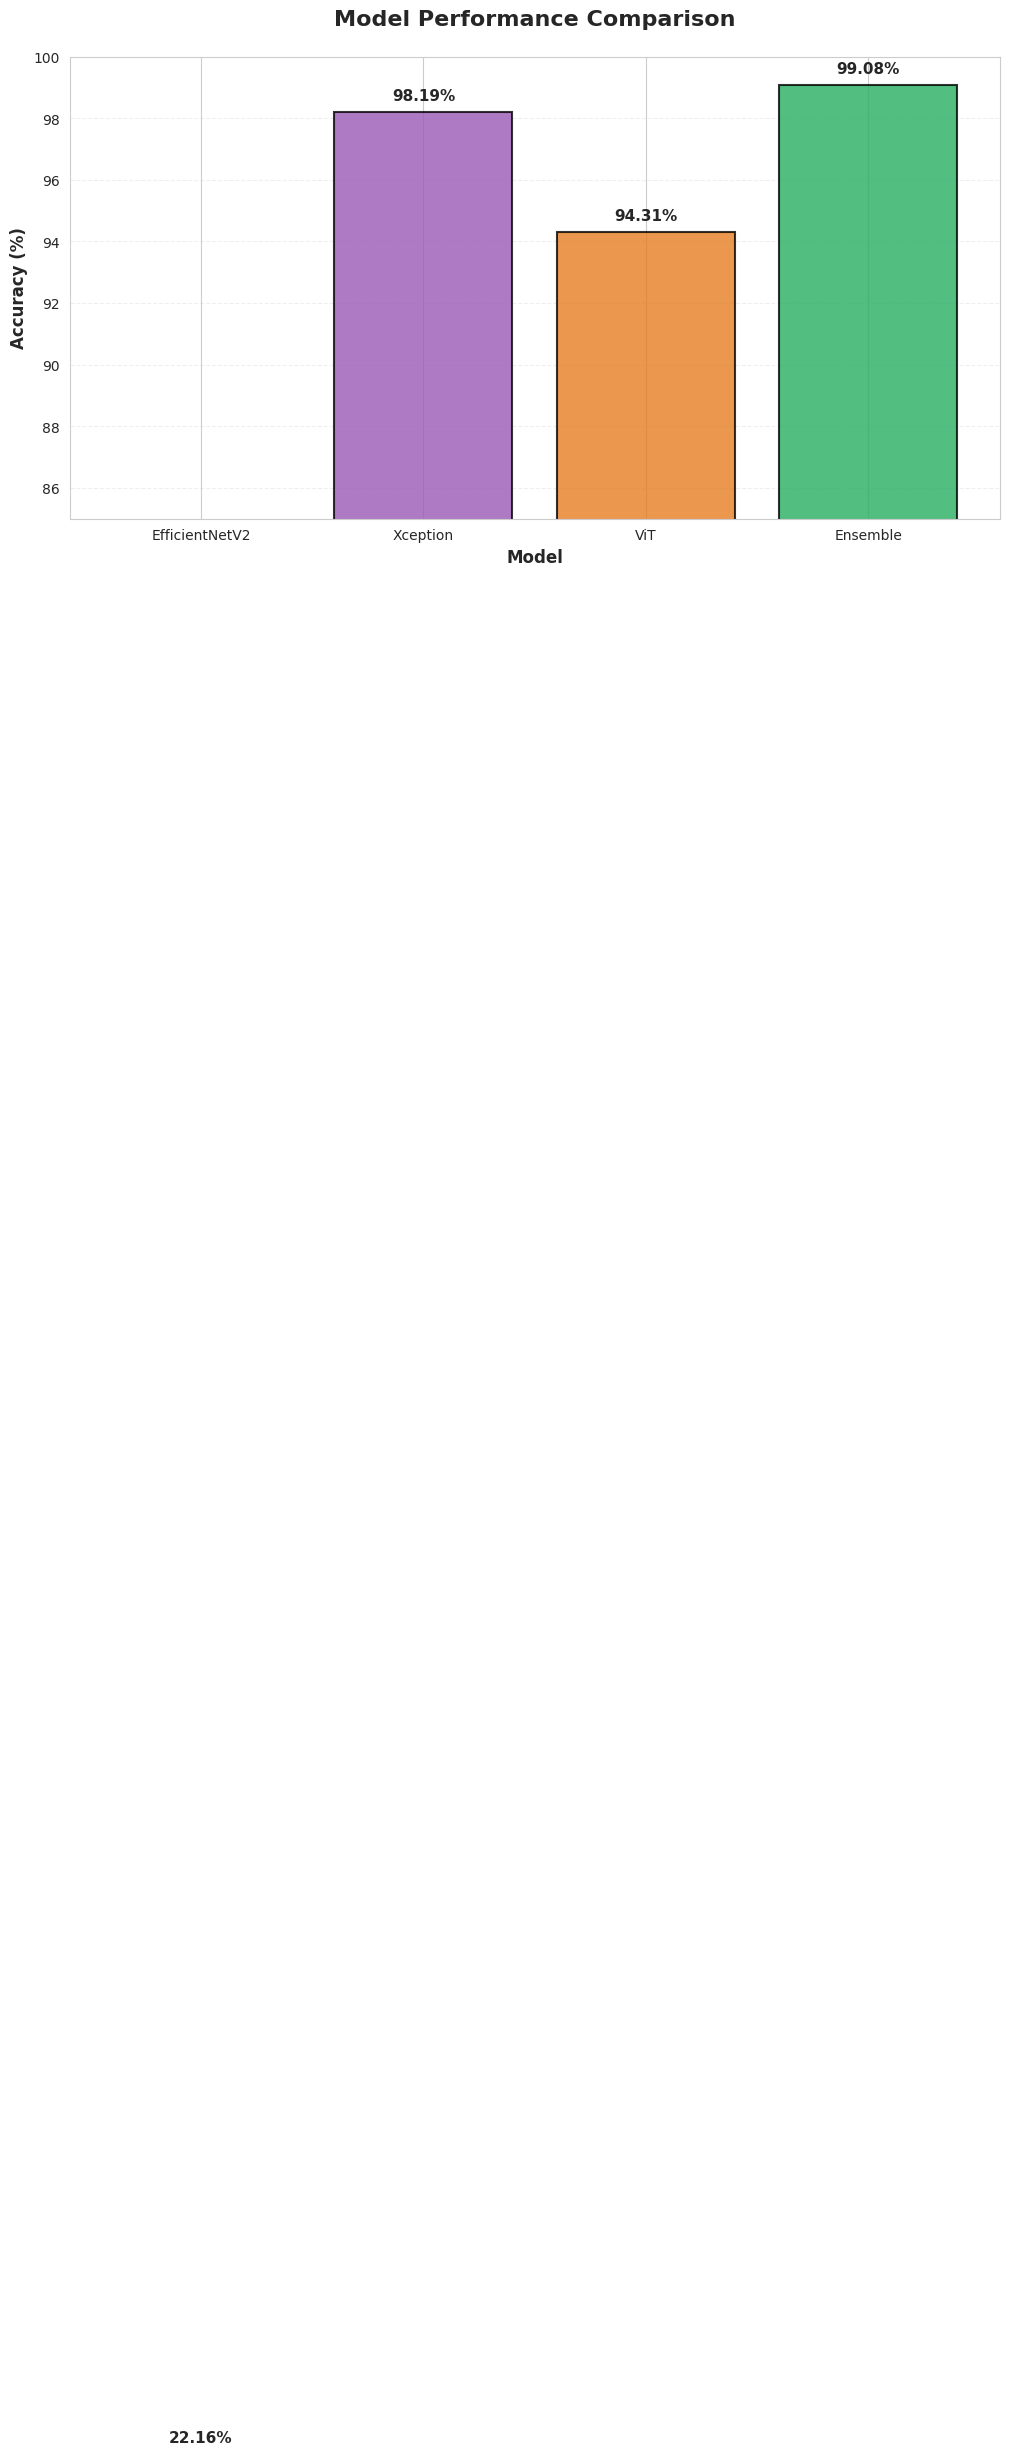

✅ Per-class accuracy chart saved: per_class_accuracy.png


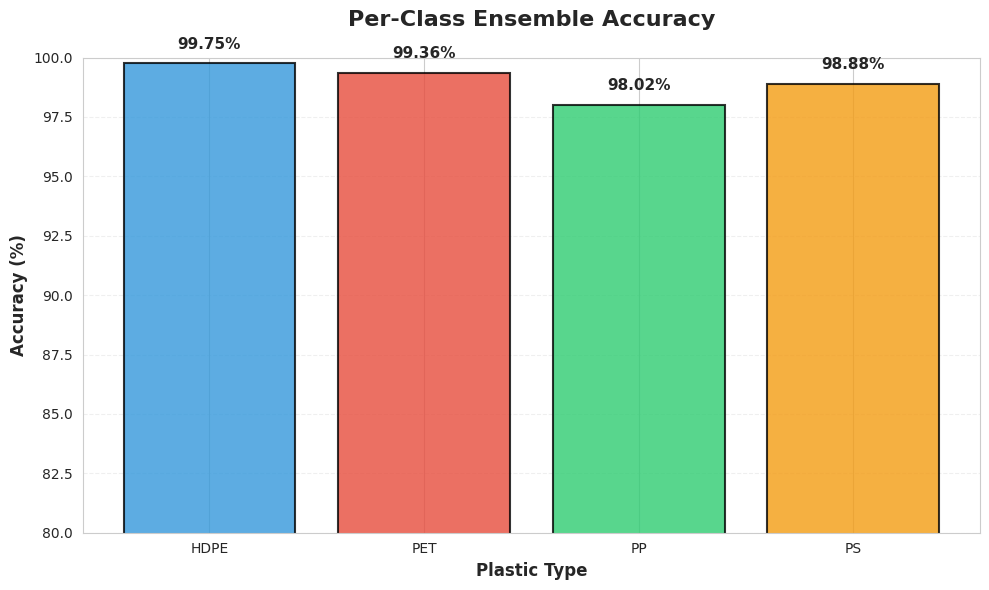

In [11]:
# =========================== CELL 11 ===========================
# Visualizations
# ==============================================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# 1. Confusion Matrix
cm = confusion_matrix(y_meta, final_predictions)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Ensemble Confusion Matrix\n', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrix saved: ensemble_confusion_matrix.png")
plt.show()

# 2. Model Comparison Bar Chart
model_names = ['EfficientNetV2', 'Xception', 'ViT', 'Ensemble']
accuracies = [eff_acc * 100, xce_acc * 100, vit_acc * 100, ensemble_acc * 100]
colors = ['#3498db', '#9b59b6', '#e67e22', '#27ae60']

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison\n', fontsize=16, fontweight='bold')
ax.set_ylim(85, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.3,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Model comparison chart saved: model_comparison.png")
plt.show()

# 3. Per-Class Accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(class_names, per_class_acc * 100, 
              color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
              edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Plastic Type', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Ensemble Accuracy\n', fontsize=16, fontweight='bold')
ax.set_ylim(80, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, acc in zip(bars, per_class_acc * 100):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
print("✅ Per-class accuracy chart saved: per_class_accuracy.png")
plt.show()

In [12]:
# =========================== CELL 12 ===========================
# Save Models and Results
# ==============================================================

print("\n" + "="*70)
print("SAVING MODELS AND RESULTS")
print("="*70)

# Save meta-learner
joblib.dump(meta_learner, 'meta_learner.pkl')
print("\n✅ Meta-learner saved: meta_learner.pkl")

# Save predictions
np.save('ensemble_predictions.npy', final_predictions)
np.save('ensemble_probabilities.npy', final_probabilities)
np.save('confusion_matrix.npy', cm)
print("✅ Predictions and confusion matrix saved")

# Create summary report
summary_data = {
    'Model': ['EfficientNetV2', 'Xception', 'ViT', 'Average', 'Ensemble'],
    'Accuracy (%)': [
        f"{eff_acc*100:.2f}",
        f"{xce_acc*100:.2f}",
        f"{vit_acc*100:.2f}",
        f"{((eff_acc + xce_acc + vit_acc)/3)*100:.2f}",
        f"{ensemble_acc*100:.2f}"
    ]
}

df_summary = pd.DataFrame(summary_data)

# Save text summary
with open('ensemble_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("HETEROGENEOUS ENSEMBLE MODEL SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write("Project: Plastic Waste Classification using Meta-Learning\n")
    f.write("Date: October 22, 2025\n\n")
    
    f.write("-"*70 + "\n")
    f.write("ARCHITECTURE\n")
    f.write("-"*70 + "\n")
    f.write("Level-0 (Base Models):\n")
    f.write(f"  1. EfficientNetV2 - Parameters: {efficientnet_model.count_params():,}\n")
    f.write(f"  2. Xception - Parameters: {xception_model.count_params():,}\n")
    f.write(f"  3. Vision Transformer - Parameters: {vit_model.count_params():,}\n\n")
    f.write("Level-1 (Meta-Learner):\n")
    f.write("  Logistic Regression (Multinomial, max_iter=1000)\n\n")
    
    f.write("-"*70 + "\n")
    f.write("PERFORMANCE RESULTS\n")
    f.write("-"*70 + "\n")
    f.write(df_summary.to_string(index=False))
    f.write(f"\n\nImprovement: +{improvement:.2f}% over best individual model\n\n")
    
    f.write("-"*70 + "\n")
    f.write("PER-CLASS ACCURACY\n")
    f.write("-"*70 + "\n")
    for name, acc in zip(class_names, per_class_acc):
        f.write(f"{name}: {acc*100:.2f}%\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("DETAILED CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n")
    f.write(classification_report(y_meta, final_predictions, target_names=class_names, digits=4))

print("✅ Summary report saved: ensemble_summary.txt")

# Save as CSV
df_summary.to_csv('model_accuracies.csv', index=False)
print("✅ CSV summary saved: model_accuracies.csv")


SAVING MODELS AND RESULTS

✅ Meta-learner saved: meta_learner.pkl
✅ Predictions and confusion matrix saved
✅ Summary report saved: ensemble_summary.txt
✅ CSV summary saved: model_accuracies.csv


In [13]:

# =========================== CELL 13 ===========================
# Final Summary Display
# ==============================================================

print("\n" + "="*70)
print("🎉 META-LEARNER ENSEMBLE TRAINING COMPLETE!")
print("="*70)

print("\n📊 FINAL RESULTS:")
print(f"   Ensemble Accuracy:     {ensemble_acc*100:.2f}%")
print(f"   Best Individual Model: {max(eff_acc, xce_acc, vit_acc)*100:.2f}%")
print(f"   Improvement:           +{improvement:.2f}%")

print("\n📁 OUTPUT FILES GENERATED:")
files = [
    "meta_learner.pkl",
    "ensemble_summary.txt",
    "model_accuracies.csv",
    "ensemble_confusion_matrix.png",
    "per_class_accuracy.png",
    "model_comparison.png",
    "ensemble_predictions.npy",
    "ensemble_probabilities.npy",
    "confusion_matrix.npy"
]

for i, file in enumerate(files, 1):
    print(f"   {i}. {file}")

print("\n✅ All files saved successfully!")
print("\n" + "="*70)
print("Ready for research paper and deployment!")
print("="*70)

# Display summary table
print("\n" + "="*70)
print("ACCURACY SUMMARY TABLE")
print("="*70)
print(df_summary.to_string(index=False))
print("="*70 + "\n")


🎉 META-LEARNER ENSEMBLE TRAINING COMPLETE!

📊 FINAL RESULTS:
   Ensemble Accuracy:     99.08%
   Best Individual Model: 98.19%
   Improvement:           +0.89%

📁 OUTPUT FILES GENERATED:
   1. meta_learner.pkl
   2. ensemble_summary.txt
   3. model_accuracies.csv
   4. ensemble_confusion_matrix.png
   5. per_class_accuracy.png
   6. model_comparison.png
   7. ensemble_predictions.npy
   8. ensemble_probabilities.npy
   9. confusion_matrix.npy

✅ All files saved successfully!

Ready for research paper and deployment!

ACCURACY SUMMARY TABLE
         Model Accuracy (%)
EfficientNetV2        22.16
      Xception        98.19
           ViT        94.31
       Average        71.55
      Ensemble        99.08

